In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.models import vgg16, vgg19
from torchvision import transforms
import torchvision.transforms.functional as TVF

In [3]:
#img_size = (800, 600)
img_size = (400, 300)
seed = 42
device = "cuda"

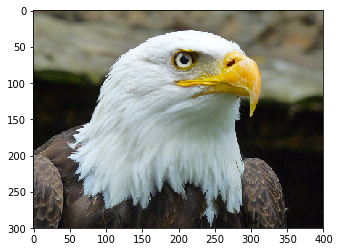

In [4]:
content_img = Image.open("data/content.jpg")
content_img = content_img.resize(img_size)
plt.imshow(content_img)
plt.show()

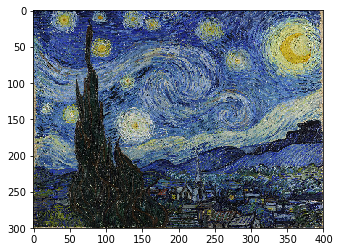

In [5]:
style_img = Image.open("data/style.jpg")
style_img = style_img.resize(img_size)
plt.imshow(style_img)
plt.show()

In [6]:
# Need to reverse the size due to PIL convention
np.random.seed(seed)
opt_image = np.random.uniform(0, 1, size=(img_size[1], img_size[0], 3))

# Filtering image can help convergence
#opt_image = ndimage.median_filter(opt_image, (8, 8, 1))

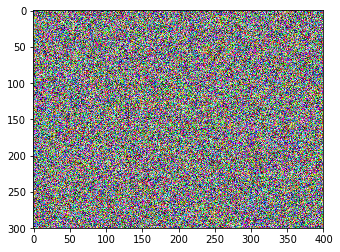

In [7]:
plt.imshow(opt_image)
plt.show()

In [8]:
model = vgg19(pretrained='imagenet')
model = model.features.to(device).eval()

for layer in model:
    layer.requires_grad = False
    
    if isinstance(layer, nn.ReLU):
        layer.inplace = False

In [9]:
# Conv layer before MaxPool (including Relu)
layer_idx = [idx - 1 for idx, layer in enumerate(model)
             if isinstance(layer, nn.MaxPool2d)]
layer_idx

[3, 8, 17, 26, 35]

In [10]:
model[17]

ReLU()

In [11]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean,
                          std=std)
    ])

In [12]:
content_tensor = transform(content_img)
content_tensor = content_tensor.unsqueeze(0).float().to(device)

style_tensor = transform(style_img)
style_tensor = style_tensor.unsqueeze(0).float().to(device)

In [13]:
#opt_image = (opt_image - np.mean(opt_image)) / np.sqrt(np.var(opt_image))
#opt_image = opt_image / 2
#opt_tensor = TVF.to_tensor(opt_image)

opt_tensor = transform(opt_image)
opt_tensor = opt_tensor.unsqueeze(0).float().to(device)
opt_tensor.requires_grad = True

In [14]:
class SaveFeatures:
    features = None

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output
    
    def close(self):
        self.hook.remove()

In [15]:
sf_content = SaveFeatures(model[layer_idx[2]])
_ = model(content_tensor)
content_hidden = sf_content.features.clone()

In [16]:
style_hidden = []
sf_style = []

for style_idx in layer_idx[1:]:
    sf = SaveFeatures(model[style_idx])
    sf_style.append(sf)
    
    _ = model(style_tensor)
    style_hidden.append(sf.features.clone())

In [17]:
def content_loss_fct(target, pred):
    loss = F.mse_loss(target, pred, reduction="sum")
    return loss

def create_gram_matrix(hidden):
    a, b, c, d = hidden.size()
    hidden_features = hidden.view(a*b, c*d)
    hidden_gram = torch.mm(hidden_features, hidden_features.t())
    hidden_gram = hidden_gram / (a*b*c*d)
    return hidden_gram

def style_loss_fct(target, pred):    
    return F.mse_loss(create_gram_matrix(target), 
                      create_gram_matrix(pred), 
                      reduction="sum")

In [18]:
max_iter = 1000
content_factor = 1e-7
optimizer = optim.LBFGS([opt_tensor], lr=0.5)

In [19]:
torch.manual_seed(seed)

run = [0]
while run[0] < max_iter:
    def lbfgs_step():
        optimizer.zero_grad()

        _ = model(opt_tensor)
        opt_hidden = sf_content.features

        content_loss = content_loss_fct(content_hidden, opt_hidden)
        
        style_loss = [style_loss_fct(style_hidden[i], sf_style[i].features.clone())
                      for i in range(len(sf_style))]
        
        content_loss = content_loss * content_factor
        style_loss = sum(style_loss)
        loss = content_loss + style_loss
        loss.backward(retain_graph=True)
        
        run[0] += 1
        if run[0] % 100 == 0:
            print(f"Iteration: {run[0]}")
            print(f"Loss : {loss.detach().cpu().numpy()}")
        return loss
        
    optimizer.step(lbfgs_step)

Iteration: 100
Loss : 5.718265056610107
Iteration: 200
Loss : 5.103299140930176
Iteration: 300
Loss : 4.9061994552612305
Iteration: 400
Loss : 4.807431221008301
Iteration: 500
Loss : 4.748033046722412
Iteration: 600
Loss : 4.7080078125
Iteration: 700
Loss : 4.679684638977051
Iteration: 800
Loss : 4.658511161804199
Iteration: 900
Loss : 4.641397953033447
Iteration: 1000
Loss : 4.627815246582031


In [20]:
mean_tensor = torch.tensor(mean).view((1, 3, 1, 1)).to(device)
std_tensor = torch.tensor(std).view((1, 3, 1, 1)).to(device)

opt_tensor_copy = opt_tensor * std_tensor + mean_tensor

In [21]:
# opt_tensor_copy.data.clamp_(0, 1)

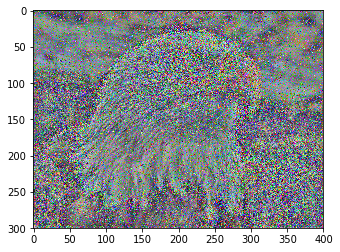

In [22]:
opt_img = opt_tensor_copy.squeeze(0).detach().cpu()
opt_img = TVF.to_pil_image(opt_img)
plt.imshow(opt_img)
plt.show()